# Load data

In [1]:
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras import initializers
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K

In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class_ids = [
    "face"
]
n_anchor_pos = 2500
class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_images = "/content/drive/MyDrive/data/images" # edit here 
path_annot = "/content/drive/MyDrive/data/annotations"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)

# Load tung File xml
# Load tat ta xml

In [4]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids

def load_data(xml_files):
  images = []
  bbox = []
  classes = []
  for xml_file in xml_files:
    image_path, boxes, class_ids = parse_annotation(xml_file)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width = img.shape[:2]
    img = cv2.resize(img, (800,800)).astype(np.float64)
    img = img/255.0
    box = []
    for xmin, ymin, xmax, ymax in boxes:
      xmin = int(xmin * 800 / width)
      ymin = int(ymin * 800 / height)
      xmax = int(xmax * 800 / width)
      ymax = int(ymax * 800 / height)
      box.append([xmin, ymin, xmax, ymax])
    images.append(img)
    bbox.append(box)
    classes.append(class_ids)

  bbox = tf.keras.utils.pad_sequences(bbox, padding="post", value=-1)
  classes = tf.keras.utils.pad_sequences(classes, padding="post", value=-1)

  return images, bbox, classes

In [5]:
images, bbox, classes = load_data(xml_files)

data = tf.data.Dataset.from_tensor_slices((images, bbox, classes))

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def showbox(img, bbox, class_ids):
  plt.imshow(img)
  bbox = bbox.numpy()
  class_ids = class_ids.numpy()
  for xmin, ymin, xmax, ymax in bbox:
    if xmin == -1 or ymin == -1 or xmax == -1 or ymax == -1:
      continue
    plt.gca().add_patch(Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,
                        edgecolor='red',
                        facecolor='none',
                        lw=1))
  plt.show()

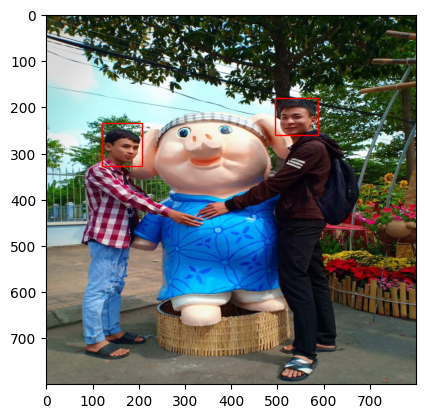

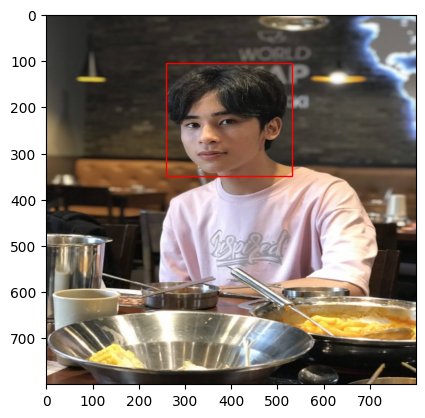

In [7]:
for image, bbox, classes in data.take(2):
  showbox(image, bbox, classes)

In [8]:
# xyxy
def to_VOC_format(width, height, center_x, center_y):
  """
  Convert center coordinate format to min max coordinateformat
  """
  x_min = center_x - 0.5 * width
  y_min = center_y - 0.5 * height
  x_max = center_x + 0.5 * width
  y_max = center_y + 0.5 * height
  return x_min, y_min, x_max, y_max
# xywh
def to_center_format(xmin_list, ymin_list, xmax_list, ymax_list):
  """
  Convert min max coordinate format to x_center, y_center, height and width format
  """
  height = ymax_list - ymin_list
  width = xmax_list - xmin_list

  center_x = xmin_list + 0.5 * width
  center_y = ymin_list + 0.5 * height

  return width, height, center_x, center_y
# predict box
def adjust_deltas(anchor_width, anchor_height, anchor_center_x, achor_center_y, dx, dy, dw, dh):
  """
  Adjust the anchor box with predicted offset
  """
  # ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
  center_x = dx * anchor_width + anchor_center_x

  # ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
  center_y = dy *  anchor_height + anchor_center_y

  # w = np.exp(dw) * anc_width[:, np.newaxis]
  width = np.exp(dw) * anchor_width

  # np.exp(dh) * anc_height[:, np.newaxis]
  height = np.exp(dh) * anchor_height

  return width, height, center_x, center_y
# tinh toan do lech
def compute_deltas(base_center_x, base_center_y, base_width, base_height, inside_anchor_width, inside_anchor_height, inside_anchor_center_x, inside_anchor_center_y):
  """
  computing offset of achor box to the groud truth box
  """
  eps = np.finfo(inside_anchor_width.dtype).eps
  inside_anchor_height = np.maximum(inside_anchor_height, eps)
  inside_anchor_width = np.maximum(inside_anchor_width, eps)

  dx = (base_center_x - inside_anchor_center_x)/ inside_anchor_width  # difference in centers of ground truth and anchor box across x axis
  dy = (base_center_y - inside_anchor_center_y)/  inside_anchor_height  # difference in centers of ground truth and anchor box across y axis
  dw = np.log(base_width/ inside_anchor_width) # log on ratio between ground truth width and anchor box width
  dh = np.log(base_height/ inside_anchor_height) # log on ratio between ground truth height and anchor box height
  return dx, dy, dw, dh

def create_center(x_stride,y_stride,n_anchor_pos=2500,width = 800,height = 800):
  x_center = np.arange(8,width,x_stride)
  y_center = np.arange(8,height,y_stride)

  center_list = np.meshgrid(x_center,y_center, sparse=False, indexing='xy')
  center_list = np.array(center_list).T.reshape(-1,2)

  return center_list

In [9]:
# load model VGG16
VGG16 = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(800,800,3)
    )

backbone = Model(inputs=[VGG16.layers[0].input], outputs=[VGG16.layers[17].output])

# number anchor of each pixel
k = 9

conv1 = Conv2D(
    512,
    kernel_size = 3,
    padding = "same",
    activation = "relu",
    kernel_initializer = initializers.RandomNormal(stddev=0.01)
)(backbone.output)

# delta regression
regressor = Conv2D(4*k,
                   kernel_size= 1,
                   activation= "linear",
                   name= "delta_regression",
                  kernel_initializer=initializers.RandomNormal(stddev=0.01),
                  bias_initializer=initializers.Zeros())(conv1) # (-1, 36)
# objectiveness score
classifier = Conv2D(k*1,
                    kernel_size= 1,
                    activation= "sigmoid",
                    name="objectivess_score",
                    kernel_initializer=initializers.RandomNormal(stddev=0.01),
                    bias_initializer=initializers.Zeros())(conv1)

RPN = Model(inputs= [backbone.input], outputs= [regressor, classifier])

58889256/58889256 [==============================] - 0s 0us/step


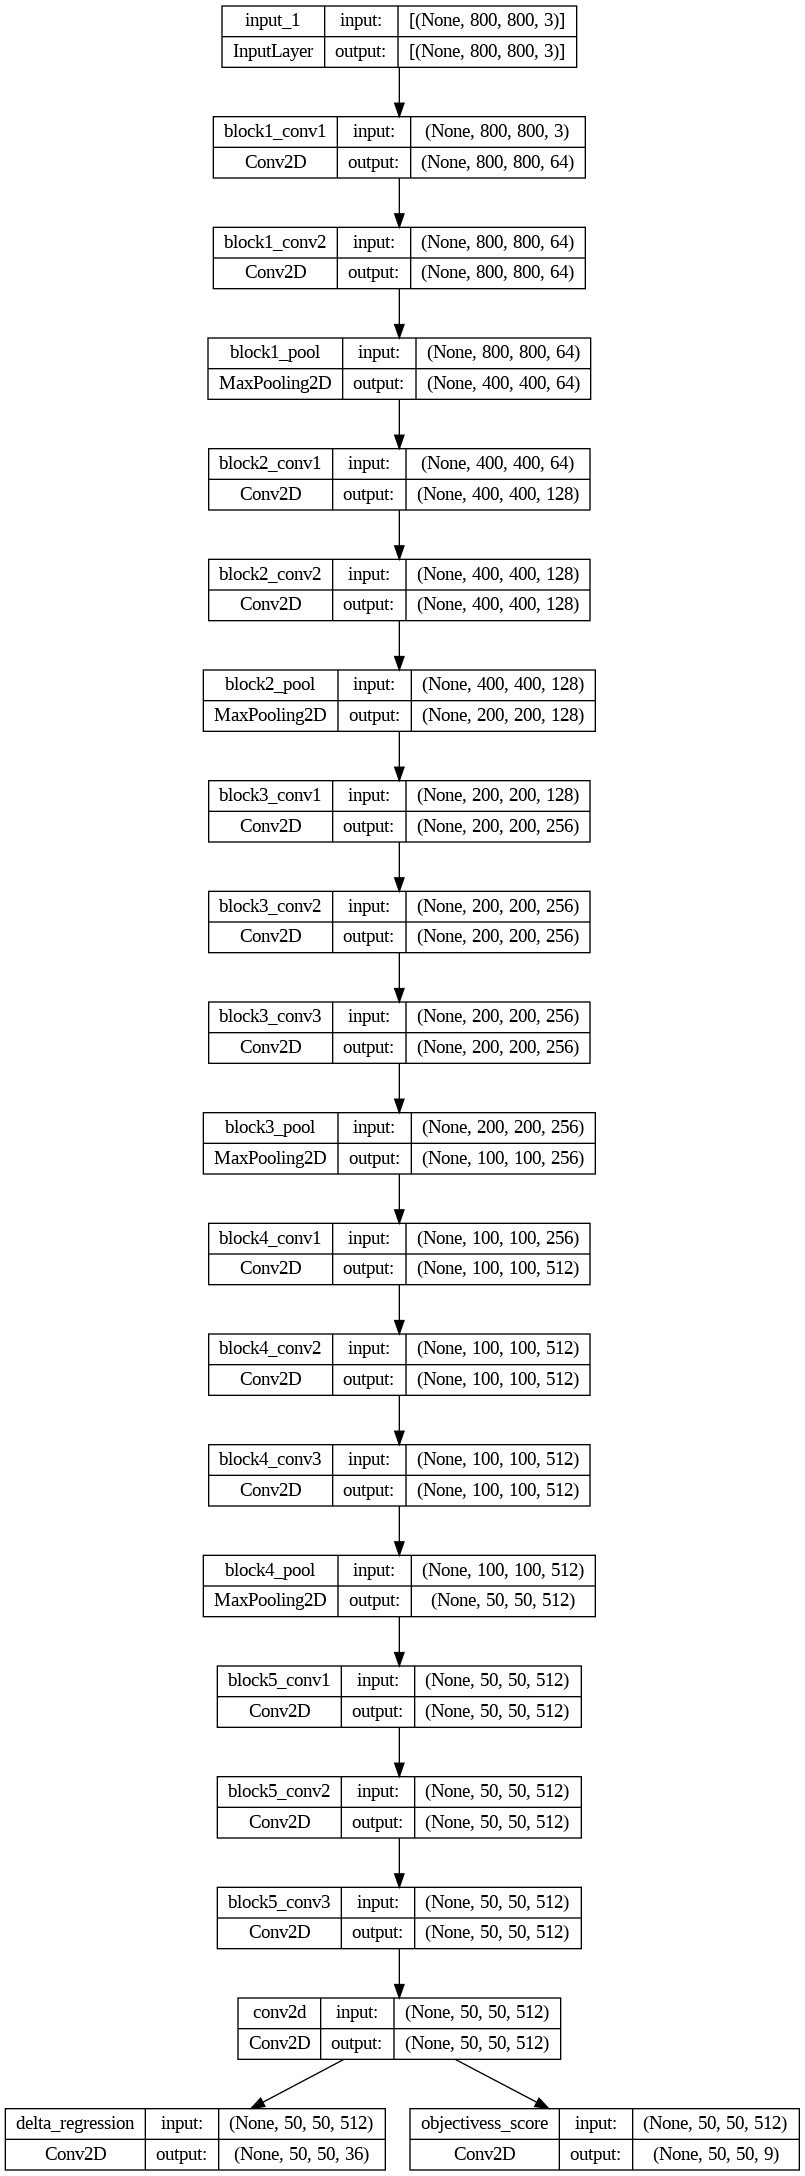

In [10]:
# plt model
from keras.utils import plot_model
plot_model(
    RPN,
    to_file="model.png",
    show_shapes=True
    )


# delta_regresion:
cos shape la: (50,50,36): Chúng ta có 36 là vì mổi pixel có 9 hình và cần dự đoán phần bù của 4 tọa độ nên sẻ có 36. Và future map của chúng ta có shape là (50,50) nên cần dự đoán  cho 2500 điểm pixel



# objectivess_score:
CHúng ta cần dự đoán xem độ tinh cậy của object có phải là có tồn tại onject hay không băng hàm sigmoil nên chúng ta cần  50x50x9.

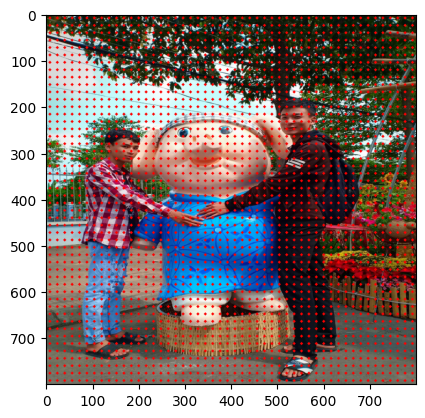

In [11]:
x_stride = int(800/50)
y_stride = int(800/50)
center_list = create_center(x_stride=x_stride,y_stride=y_stride)
img_ = []
for image, bbox, classes in data:
  img_ = image*255
  img_ = img_.numpy()
  img_ = img_.astype(np.uint8)
  break

plt.figure()
for i in range(n_anchor_pos):
  cv2.circle(img_, (int(center_list[i][0]), int(center_list[i][1])), 1, (255, 0, 0), thickness=4)

plt.imshow(img_)
plt.show()

In [12]:
def creat_Anchor(center_list, anchor_ratio_list=[0.5, 1, 2], anchor_scale_list= [8, 16, 32]):
  count = 0
  # total possble anchors
  n_anchors = n_anchor_pos * len(anchor_ratio_list) * len(anchor_scale_list)

  anchor_list = np.zeros(shape=(n_anchors, 4))

  for center_x, center_y in center_list:
    for ratio in anchor_ratio_list:
      for scale in anchor_scale_list:
        # compute height and width and scale them by constant factor
        h = pow(pow(scale, 2)/ ratio, 0.5)
        w = h * ratio

        # as h and w would be really small, we will scale them with some constant (in our case, stride width and height)
        h *= x_stride
        w *= y_stride


        # * at this point we have height and width of anchor and centers of anchor locations
        # putting anchor 9 boxes at each anchor locations
        anchor_xmin = center_x - 0.5 * w
        anchor_ymin = center_y - 0.5 * h
        anchor_xmax = center_x + 0.5 * w
        anchor_ymax = center_y + 0.5 * h
        # append the anchor box to anchor list
        anchor_list[count] = [anchor_xmin, anchor_ymin, anchor_xmax, anchor_ymax]
        count += 1
  return anchor_list

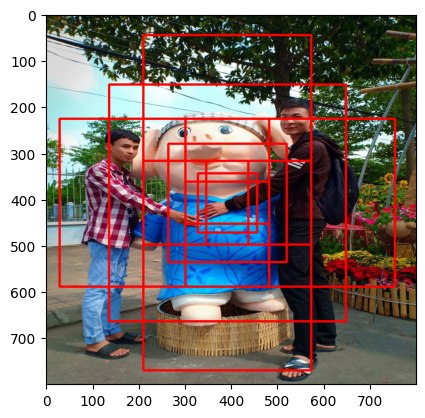

In [13]:
anchor_list= creat_Anchor(center_list)

img_ = []
for image, bbox, classes in data:
  img_ = image*255
  img_ = img_.numpy()
  img_ = img_.astype(np.uint8)
  break

for i in range(11025, 11034):  # 1250 * 9 = 11025 (9 anchors corresponds to mid anchor center)
    x_min = int(anchor_list[i][0])
    y_min = int(anchor_list[i][1])
    x_max = int(anchor_list[i][2])
    y_max = int(anchor_list[i][3])
    cv2.rectangle(img_, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=3)

plt.imshow(img_)
plt.show()

In [14]:
def filter_Anchors(anchor_list, height, width):
  # filter anchor box out image or small
  # id
  inside_anchor_idx_list = np.where(
      (anchor_list[:,0] >=0) &
      (anchor_list[:,1] >=0) &
      (anchor_list[:,2] <= width) &
      (anchor_list[:,3] <= height),
  )
  inside_anchor_list = anchor_list[inside_anchor_idx_list]
  return inside_anchor_list, np.array(inside_anchor_idx_list), np.array(inside_anchor_idx_list).shape[1
                                                                                                      ]

In [15]:
inside_anchor_list, inside_anchor_idx_list, n_inside_anchor = filter_Anchors(anchor_list, 800, 800)

In [16]:
inside_anchor_list.shape, inside_anchor_idx_list.shape[1], n_inside_anchor

((8940, 4), 8940, 8940)

8940


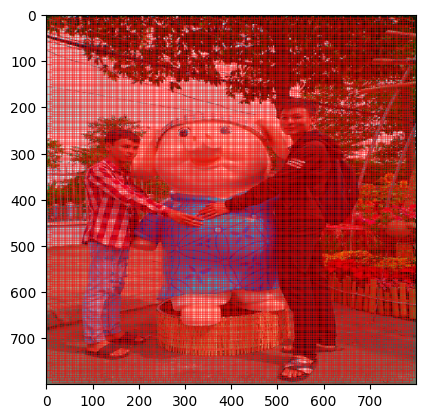

In [17]:
img_ = []
for image, bbox, classes in data:
  img_ = image*255
  img_ = img_.numpy()
  img_ = img_.astype(np.uint8)
  break
dem = 0
for i in range(0, n_inside_anchor):  # 1250 * 9 = 11025 (9 anchors corresponds to mid anchor center)
    x_min = int(inside_anchor_list[i][0])
    y_min = int(inside_anchor_list[i][1])
    x_max = int(inside_anchor_list[i][2])
    y_max = int(inside_anchor_list[i][3])
    cv2.rectangle(img_, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=1)
    dem += 1
print(dem)
plt.imshow(img_)
plt.show()

In [18]:
def IOU(box1, box2):
    """
    Compute overlap (IOU) between box1 and box2
    """

    # ------calculate coordinate of overlapping region------
    # take max of x1 and y1 out of both boxes
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])

    # take min of x2 and y2 out of both boxes
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # check if they atleast overlap a little
    if (x1 < x2 and y1 < y2):
        # ------area of overlapping region------
        width_overlap = (x2 - x1)
        height_overlap = (y2 - y1)
        area_overlap = width_overlap * height_overlap
    else:
        # there is no overlap
        return 0

    # ------computing union------
    # sum of area of both the boxes - area_overlap

    # height and width of both boxes
    width_box1 = (box1[2] - box1[0])
    height_box1 = (box1[3] - box1[1])

    width_box2 = (box2[2] - box2[0])
    height_box2 = (box2[3] - box2[1])

    # area of box1 and box2
    area_box1 = width_box1 * height_box1
    area_box2 = width_box2 * height_box2

    # union (including 2 * overlap area (double count))
    area_union_overlap = area_box1 + area_box2

    # union
    area_union = area_union_overlap - area_overlap

    # compute IOU
    iou = area_overlap/ area_union

    return iou

In [19]:
def get_iou(ground_bbox, anchor_bbox):
  iou_list = np.zeros((anchor_bbox.shape[0], ground_bbox.shape[0]))
  for gt_idx, gt_box in enumerate(ground_bbox):
    for anchor_idx, anchor_box in enumerate(anchor_bbox):
      iou_list[anchor_idx][gt_idx] = IOU(gt_box, anchor_box)
  best_gt = iou_list.argmax(axis=1)
  max_iou = iou_list.max(axis=1)
  return iou_list,best_gt,max_iou


In [20]:
anchor_list

array([[ -37.254834  ,  -82.50966799,   53.254834  ,   98.50966799],
       [ -82.50966799, -173.01933598,   98.50966799,  189.01933598],
       [-173.01933598, -354.03867197,  189.01933598,  370.03867197],
       ...,
       [ 701.49033201,  746.745166  ,  882.50966799,  837.254834  ],
       [ 610.98066402,  701.49033201,  973.01933598,  882.50966799],
       [ 429.96132803,  610.98066402, 1154.03867197,  973.01933598]])

In [21]:
for i in data.take(1):
  bbox =i[1].numpy()
  iou_list, best_gt, max_iou = get_iou(bbox, inside_anchor_list)
iou_list.shape, best_gt.shape, iou_list[:-20], best_gt[:-20]

((8940, 2),
 (8940,),
 array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [22]:
df = pd.DataFrame(iou_list)
df.rename(columns = {0:'iou_0'}, inplace = True)
df.rename(columns = {1:'iou_1'}, inplace = True)
df["anchor_idx"] = inside_anchor_idx_list.T
df.set_index("anchor_idx")
df["best_gt"] = best_gt
df["max_iou"] = max_iou
df.index = df["anchor_idx"]
df.to_csv("data.csv")
df.head()

,iou_0,iou_1,anchor_idx,best_gt,max_iou
anchor_idx,,,,,
1404,0.0,0.0,1404,0,0.0
1413,0.0,0.0,1413,0,0.0
1422,0.0,0.0,1422,0,0.0
1431,0.0,0.0,1431,0,0.0
1440,0.0,0.0,1440,0,0.0


In [23]:
df.index

Index([ 1404,  1413,  1422,  1431,  1440,  1449,  1458,  1467,  1476,  1485,
       ...
       21006, 21015, 21024, 21033, 21042, 21051, 21060, 21069, 21078, 21087],
      dtype='int64', name='anchor_idx', length=8940)

In [24]:
best_iou = df.drop(["anchor_idx", "max_iou", "best_gt"],axis=1).max().values

best_anchors = df.drop(["anchor_idx", "max_iou", "best_gt"],axis= 1).values.argmax(axis= 0)

# get all the anchor boxes having same IOU score
top_anchors = np.where(iou_list == best_iou)[0]
print(f"Anchor boxes with same IOU score: {top_anchors}")


Anchor boxes with same IOU score: [ 738  743  748  924  929  934 1120 1126 1132 6530 6536 6542 6776 6782
 6788]


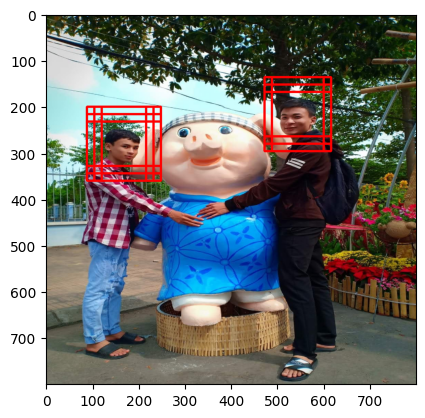

In [25]:
img_ = []
for image, bbox, classes in data.take(1):
  img_ = image*255
  img_ = img_.numpy()
  img_ = img_.astype(np.uint8)
  break
dem = 0
for i in top_anchors:
  dem += 1
  x_min = int(inside_anchor_list[i][0])
  y_min = int(inside_anchor_list[i][1])
  x_max = int(inside_anchor_list[i][2])
  y_max = int(inside_anchor_list[i][3])
  cv2.rectangle(img_, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=3)


plt.imshow(img_)
plt.show()

In [26]:
top_anchors.shape, dem

((15,), 15)

In [27]:
label_column = np.zeros(inside_anchor_list.shape[0], dtype=np.int16)
label_column.fill(-1)
label_column[top_anchors] = 1
label_column[np.where(max_iou >= 0.5)] = 1
label_column[np.where(max_iou < 0.2)] = 0
label_column.shape

(8940,)

In [28]:
data1 = pd.DataFrame(label_column)
data1.to_csv("asasas.csv")

In [29]:
df

,iou_0,iou_1,anchor_idx,best_gt,max_iou
anchor_idx,,,,,
1404,0.0,0.0,1404,0,0.0
1413,0.0,0.0,1413,0,0.0
1422,0.0,0.0,1422,0,0.0
1431,0.0,0.0,1431,0,0.0
1440,0.0,0.0,1440,0,0.0
...,...,...,...,...,...
21051,0.0,0.0,21051,0,0.0
21060,0.0,0.0,21060,0,0.0
21069,0.0,0.0,21069,0,0.0


In [30]:
def sample_anchors_pre(iou_list,label_column,best_gt, n_samples= 256, neg_ratio = 0.5):
  n_foreground = int((1-neg_ratio) * n_samples)
  n_background = n_samples - n_foreground

  foreground_index_list = np.where(label_column == 1)[0] # 15
  background_index_list = np.where(label_column == 0)[0] # 8794

  if len(foreground_index_list) > n_foreground:
    index_delete = foreground_index_list[n_background:]
    label_column[index_delete] = -1

  if len(foreground_index_list) < n_foreground:
    diff = n_foreground - len(foreground_index_list)
    n_background += diff


  # check if we have excessive background samples
  if len(background_index_list) > n_background:
    # mark excessive samples as -1 (ignore)
    ignore_index = background_index_list[n_background:]
    label_column[ignore_index] = -1
  best_gt[np.where(label_column == -1)] = -1
  return np.array(iou_list), np.array(label_column), np.array(best_gt)

In [31]:
iou_list.shape, label_column.shape

((8940, 2), (8940,))

In [32]:
iou_after, label_after, best_gt = sample_anchors_pre(iou_list,label_column,best_gt)
iou_after.shape, label_after.shape, best_gt.shape

((8940, 2), (8940,), (8940,))

In [33]:
iou_after[label_after == 0].shape, iou_after[label_column == 1].shape

((241, 2), (15, 2))

In [34]:
iou_after.shape, label_after.shape

((8940, 2), (8940,))

In [35]:
inside_anchor_width, inside_anchor_height, inside_anchor_center_x, inside_anchor_center = to_center_format(
    inside_anchor_list[:,0],
    inside_anchor_list[:,1],
    inside_anchor_list[:,2],
    inside_anchor_list[:,3]
)
bbox_list = []
for image, bbox, classes in data.take(1):
  bbox = bbox.numpy()
  bbox_list.append(bbox)

gt_coordinates = []
dem = 0
for idx in best_gt:
  dem += 1
  if idx != -1:
    gt_coordinates.append(bbox_list[0][idx])
  else:
    gt_coordinates.append(np.array([-1,-1,-1,-1]))
gt_coordinates = np.array(gt_coordinates)

# convert to xy wh
base_width, base_height, base_center_x, base_center_y =  to_center_format(
    gt_coordinates[:, 0],
    gt_coordinates[:, 1],
    gt_coordinates[:, 2],
    gt_coordinates[:, 3])

In [36]:
dem

8940

In [37]:
dx, dy,dw,dh = compute_deltas(base_center_x, base_center_y, base_width,base_height,inside_anchor_width ,inside_anchor_height,inside_anchor_center_x ,inside_anchor_center)
dx.shape, dy.shape, dw.shape, dh.shape

<ipython-input-8-24e6c65064e7>:52: RuntimeWarning: divide by zero encountered in log
  dw = np.log(base_width/ inside_anchor_width) # log on ratio between ground truth width and anchor box width
<ipython-input-8-24e6c65064e7>:53: RuntimeWarning: divide by zero encountered in log
  dh = np.log(base_height/ inside_anchor_height) # log on ratio between ground truth height and anchor box height


((8940,), (8940,), (8940,), (8940,))

In [38]:
dx.shape, dy.shape, dw.shape, dh.shape

((8940,), (8940,), (8940,), (8940,))

In [39]:
# labels for all possible anchors
label_list = np.empty(50*50*3*3, dtype = np.float32)
label_list.fill(-1)
label_list[inside_anchor_idx_list] = label_after
label_list = np.expand_dims(label_list, -1)
label_list = np.expand_dims(label_list, 0)
label_list.shape

(1, 22500, 1)

In [40]:
offset_list = np.empty(shape=anchor_list.shape, dtype=np.float32)
offset_list.fill(0)
offset_list[inside_anchor_idx_list] = np.stack([dx, dy, dw, dh], axis=-1)
# offset_list = np.expand_dims(offset_list)
offset_list.shape, label_list.shape

((22500, 4), (1, 22500, 1))

In [41]:
# combine deltas and objectiveness score in one array
offset_list_label_list = np.column_stack((offset_list, label_list[0]))[np.newaxis,:]

In [42]:
offset_list.shape, label_list.shape

((22500, 4), (1, 22500, 1))

In [43]:
n_anchors = 50 * 50 * 9
def smooth_l1_loss(y_true, y_pred):
    """
    Calculates Smooth L1 loss
    """

    # Take absolute difference
    x = K.abs(y_true - y_pred)

    # Find indices of values less than 1
    mask = K.cast(K.less(x, 1.0), "float32")
    # Loss calculation for smooth l1
    loss = (mask * (0.5 * x ** 2)) + (1 - mask) * (x - 0.5)
    return loss


def custom_l1_loss(y_true, y_pred):
    """
    Regress anchor offsets(deltas) * only consider foreground boxes
    """
    offset_list= y_true[:,:,:-1]
    label_list = y_true[:,:,-1]

    # reshape output by the model
    y_pred = tf.reshape(y_pred, shape= (-1, n_anchors, 4))

    positive_idxs = tf.where(K.equal(label_list, 1)) # select only foreground boxes

    # Select positive predicted bbox shifts
    bbox = tf.gather_nd(y_pred, positive_idxs)

    target_bbox = tf.gather_nd(offset_list, positive_idxs)
    loss = smooth_l1_loss(target_bbox, bbox)

    return K.mean(loss)

def custom_binary_loss(y_true, y_pred_objectiveness):
    '''
    Select both foreground and background class and compute cross entropy
    '''

    y_pred = tf.reshape(y_pred_objectiveness, shape= (-1, n_anchors))
    y_true = tf.squeeze(y_true, -1)

    # Find indices of positive and negative anchors, not neutral
    indices = tf.where(K.not_equal(y_true, -1)) # ignore -1 labels

    # Pick rows that contribute to the loss and filter out the rest.
    rpn_match_logits = tf.gather_nd(y_pred, indices)
    anchor_class = tf.gather_nd(y_true, indices)


    # Cross entropy loss
    loss = K.binary_crossentropy(target=anchor_class,
                                output=rpn_match_logits
                                )
    loss = K.switch(tf.size(loss) > 0, K.mean(loss), tf.constant(0.0))

    return loss

RPN.compile(loss = [custom_l1_loss, custom_binary_loss], optimizer= "adam")

In [44]:
y = np.expand_dims(image, 0)
y.shape

(1, 800, 800, 3)

In [45]:
offset_list_label_list = np.stack(offset_list_label_list, axis=0)
offset_list_label_list.shape

(1, 22500, 5)

In [46]:
label_list = np.stack(label_list, axis=0)
label_list.shape

(1, 22500, 1)

In [47]:
y.shape,offset_list_label_list.shape, label_list.shape

((1, 800, 800, 3), (1, 22500, 5), (1, 22500, 1))

In [48]:
a = RPN.predict(y)
a[0].shape, a[1].shape

1/1 [==============================] - 6s 6s/step


((1, 50, 50, 36), (1, 50, 50, 9))

In [49]:
loss = RPN.fit(y,[offset_list_label_list, label_list], epochs= 1000)

Epoch 1/1000
1/1 [==============================] - 15s 15s/step - loss: 0.7399 - delta_regression_loss: 0.0434 - objectivess_score_loss: 0.6965
Epoch 2/1000
1/1 [==============================] - 0s 219ms/step - loss: 5.8854 - delta_regression_loss: 5.0585 - objectivess_score_loss: 0.8270
Epoch 3/1000
1/1 [==============================] - 0s 219ms/step - loss: 0.7147 - delta_regression_loss: 0.0361 - objectivess_score_loss: 0.6786
Epoch 4/1000
1/1 [==============================] - 0s 219ms/step - loss: 0.5466 - delta_regression_loss: 0.0639 - objectivess_score_loss: 0.4827
Epoch 5/1000
1/1 [==============================] - 0s 219ms/step - loss: 1.5716 - delta_regression_loss: 1.3109 - objectivess_score_loss: 0.2607
Epoch 6/1000
1/1 [==============================] - 0s 222ms/step - loss: 0.5132 - delta_regression_loss: 0.3206 - objectivess_score_loss: 0.1927
Epoch 7/1000
1/1 [==============================] - 0s 220ms/step - loss: 0.5041 - delta_regression_loss: 0.0282 - objectives

In [50]:
y = np.expand_dims(image, 0)
y.shape

(1, 800, 800, 3)

In [80]:
box, score = RPN.predict(y)

1/1 [==============================] - 0s 26ms/step


In [81]:
box = box.reshape((22500,4))

In [82]:
score.shape

(1, 50, 50, 9)

In [83]:
score = score.reshape(22500,)

In [84]:
offset_list_label_list.shape, label_list.shape

((1, 22500, 5), (1, 22500, 1))

In [85]:
dx = box[:,0]
dy = box[:,1]
dw = box[:,2]
dh = box[:,3]

anchor_width, anchor_height, anchor_center_x, anchor_center_y = to_center_format(anchor_list[:,0], anchor_list[:,1], anchor_list[:,2], anchor_list[:,3])

In [86]:
anchor_width.shape, anchor_height.shape, anchor_center_x.shape, anchor_center_y.shape

((22500,), (22500,), (22500,), (22500,))

In [87]:
# def adjust_deltas(anchor_width, anchor_height, anchor_center_x, achor_center_y, dx, dy, dw, dh):
width, height, center_x, center_y = adjust_deltas(anchor_width, anchor_height,anchor_center_x ,anchor_center_y,dx,dy,dw,dh)

In [88]:
#def to_VOC_format(width, height, center_x, center_y):

xmin, ymin, xmax, ymax = to_VOC_format(width, height, center_x, center_y)

In [89]:
boxed = np.column_stack((xmin, ymin, xmax, ymax))
boxed.shape

(22500, 4)

In [90]:
boxed = np.clip(boxed, 0, 800)

In [91]:
boxlon = np.where(score>0.91)
score = score[boxlon]
box_plot = boxed[boxlon]

In [92]:
score.shape, box_plot.shape

((1532,), (1532, 4))

In [93]:
box_plot.shape

(1532, 4)

In [94]:
box_plot.shape

(1532, 4)

In [95]:
for i in box_plot:
  print(i)
  break

[0. 0. 0. 0.]


In [97]:
def non_max_suppression(boxes, scores, threshold=0.7):
    """
    Perform non-max suppression on a set of bounding boxes and corresponding scores.

    :param boxes: a list of bounding boxes in the format [xmin, ymin, xmax, ymax]
    :param scores: a list of corresponding scores
    :param threshold: the IoU (intersection-over-union) threshold for merging bounding boxes
    :return: a list of indices of the boxes to keep after non-max suppression
    """
    # Sort the boxes by score in descending order
    order = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
    keep = []
    while order:
        i = order.pop(0)
        keep.append(i)
        for j in order:
            # Calculate the IoU between the two boxes
            intersection = max(0, min(boxes[i][2], boxes[j][2]) - max(boxes[i][0], boxes[j][0])) * \
                           max(0, min(boxes[i][3], boxes[j][3]) - max(boxes[i][1], boxes[j][1]))
            union = (boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1]) + \
                    (boxes[j][2] - boxes[j][0]) * (boxes[j][3] - boxes[j][1]) - intersection
            iou = intersection / union

            # Remove boxes with IoU greater than the threshold
            if iou > threshold:
                order.remove(j)
    return keep

In [98]:
box_plot.shape, score.shape

((1532, 4), (1532,))

In [ ]:
keep = non_max_suppression(box_plot, score, threshold=0.7)
keep

In [100]:
box_plot_ed = box_plot[keep]
score_ed = score[keep]

In [102]:
len(keep)


1031

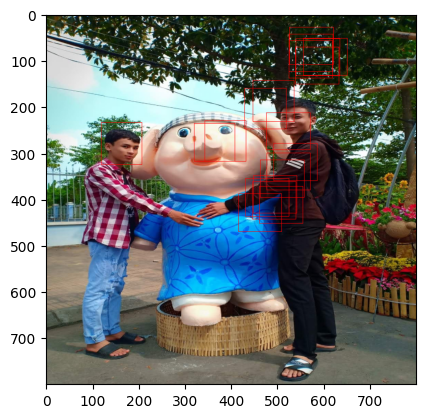

In [106]:
img_ = []
for image, bbox, classes in data:
  img_ = image*255
  img_ = img_.numpy()
  img_ = img_.astype(np.uint8)
  break

dem = 0
for i in box_plot_ed[40:60]:
  x_min = int(i[0])
  y_min = int(i[1])
  x_max = int(i[2])
  y_max = int(i[3])
  dem += 1


  cv2.rectangle(img_, (x_min,y_min), (x_max, y_max), color=(255, 0, 0), thickness=1)

plt.imshow(img_)
plt.show()